# 1 Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# 2 Data preparation

In [2]:
train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')

#concatinate train and test to later control train-test split
data = pd.concat([train,test])
print("data shape:", data.shape)
print("number of columns with null values:", data.isnull().any().sum())

data shape: (1097231, 289)
number of columns with null values: 44


In [3]:
#drop columns with null values
data = data.dropna(axis=1)
print("new shape of data:", data.shape)

new shape of data: (1097231, 245)


In [4]:
#separate class column from other features
X = data.drop('isFraud', axis = 1)
X = pd.get_dummies(X) #one-hot encoding on categorical features
y = data['isFraud']

# 3 Decision Tree
## 3.1 Decision Tree with unbalanced data

In [5]:
#split test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(768061, 244)
(329170, 244)
(768061,)
(329170,)


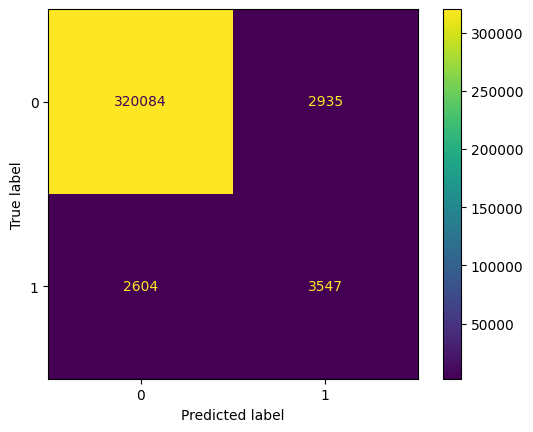

In [6]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(cm)
CM.plot()

Here we calculate the false positive rate and the false negative rate. The first says how likey a transaction will be predicted to be fraud, when in truth the transaction is not fraud. The second says how likey a transaction will be predicted to not be fraud, when in truth the transaction is fraud. It is important to keep false negative rate low. 

In [7]:
fp = cm[0][1]
tn = cm[0][0]
fpr = fp/(fp+tn)
print('false positive rate =',fpr)

fn = cm[1][0]
tp = cm[1][1]
fnr = fn/(fn+tp)
print('false negative rate =',fnr)

false positive rate = 0.009086152826923493
false negative rate = 0.42334579743131195


In [8]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('accuracy:',acc)
print('recall:',rec)
print('precision:',prec)
print('f1 score:',f1)

accuracy: 0.9831728286295836
recall: 0.576654202568688
precision: 0.5472076519592718
f1 score: 0.5615451595028893


This model meets the success criteria of an accuracy rate of at least 80% and false positive rate of at most 5%. But because the data that was used to train this model is so unbalanced, we look to the f1 score. But this score is less than 80%. This means this model fails the success criteria.

It is also important to note that the while the false positive rate is 0.9%, the false negative rate is about 42%. 

## 3.2 Decision Tree with Under-Samping

To manage the unbalanced data, we will use the under-sampling technique to balance the data. Under-sampling randomly takes data points from the majority class to match the number of data points in the minority class. Under-sampling can get rid of important data points, but it may also improve the false negative rate and the f1 score. 

In [9]:
#split data by class
class0 = data[data['isFraud'] == 0]
class1 = data[data['isFraud'] == 1]
print('class 0:', class0.shape)
print('class 1:', class1.shape)

class 0: (1076568, 245)
class 1: (20663, 245)


In [10]:
#under-sample the majority class so it is balanced with the minority class
under_class0 = resample(class0, replace=False, n_samples=class1.shape[0], random_state=42)
print('new class 0:', under_class0.shape)
print('new class 1:', class1.shape)
under_data = pd.concat([under_class0, class1])

new class 0: (20663, 245)
new class 1: (20663, 245)


In [11]:
X = under_data.drop('isFraud', axis = 1)
X = pd.get_dummies(X)
y = under_data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33060, 244)
(8266, 244)
(33060,)
(8266,)


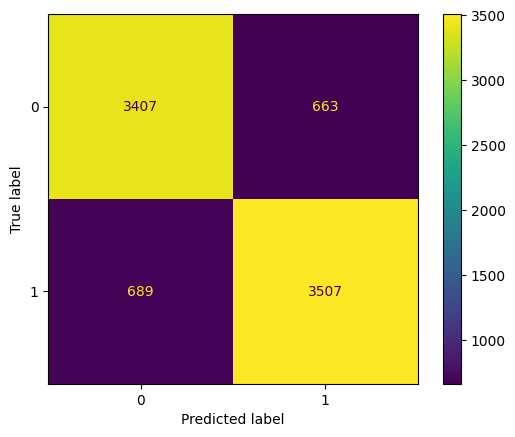

In [12]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(cm)
CM.plot()

In [13]:
fp = cm[0][1]
tn = cm[0][0]
fpr = fp/(fp+tn)
print('false positive rate =',fpr)

fn = cm[1][0]
tp = cm[1][1]
fnr = fn/(fn+tp)
print('false negative rate =',fnr)

false positive rate = 0.1628992628992629
false negative rate = 0.1642040038131554


In [14]:
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('accuracy:',acc)
print('recall:',rec)
print('precision:', prec)
print('f1 score:',f1)

accuracy: 0.8364384224534237
recall: 0.8357959961868446
precision: 0.8410071942446044
f1 score: 0.8383934974898398


By using under-sampling we reduced the accuracy from 98% to 84%, but the accuracy still meets the success criteria. The false potivite rate also increased from 0.9% to 16%, so it doesn't meet our success criteria anymore.

By under-sampling we were able to decrease the false negative rate from 42% to 16%. The f1 score also increased from 56% to 84%.

This model's metric results are an overall significant improvement over the previous model's metric results.

## 3.3 Decision Tree with Stratified Cross-Validation and Under-Sampling

Stratified Cross-Validation is used here to see the variation in the train-test splits and how much the metrics change.

In [15]:
acc_list = []
f1_list = []
fpr_list = []
fnr_list = []
folds = 5
i = 1

for train, test in StratifiedKFold(n_splits=folds,random_state=1, shuffle=True).split(X, y):
    print(i)
    i+=1
    
    x_train_one_fold, x_test_one_fold = X.iloc[train], X.iloc[test]
    y_train_one_fold, y_test_one_fold = y.iloc[train], y.iloc[test]
    tree = DecisionTreeClassifier(criterion='entropy')
    tree.fit(x_train_one_fold, y_train_one_fold)
    
    y_pred = tree.predict(x_test_one_fold)
    cm = confusion_matrix(y_test_one_fold, y_pred)
    fp = cm[0][1]
    tn = cm[0][0]
    fn = cm[1][0]
    tp = cm[1][1]
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)
    
    acc_list.append(accuracy_score(y_test_one_fold, y_pred))
    f1_list.append(f1_score(y_test_one_fold, y_pred, pos_label=1))
    fpr_list.append(fpr)
    fnr_list.append(fnr)

1
2
3
4
5


In [16]:
for fold in range(folds):
    print('accuracy=',round(acc_list[fold],4),'\tf1_score=',round(f1_list[fold],4), end='')
    print('\tfpr=',round(fpr_list[fold],4), '\tfnr=',round(fnr_list[fold],4))

accuracy= 0.8364 	f1_score= 0.8376	fpr= 0.1706 	fnr= 0.1565
accuracy= 0.8365 	f1_score= 0.8382	fpr= 0.174 	fnr= 0.153
accuracy= 0.841 	f1_score= 0.8429	fpr= 0.1711 	fnr= 0.1469
accuracy= 0.8509 	f1_score= 0.8526	fpr= 0.1602 	fnr= 0.1379
accuracy= 0.8376 	f1_score= 0.8373	fpr= 0.1605 	fnr= 0.1643


The best fold is fold 4. The accuracy and f1 score is the highest, and the false positive rate and false negative rate are the lowest. In this fold, accuracy and f1 are both about 85%, the false positive rate is 16%, and false negative rate is less than 14%.